In [230]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load and Explore Data

In [90]:
data_raw = pd.read_csv('data/train.csv')
train=data_raw.copy()


## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [91]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Check for missing data

In [93]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

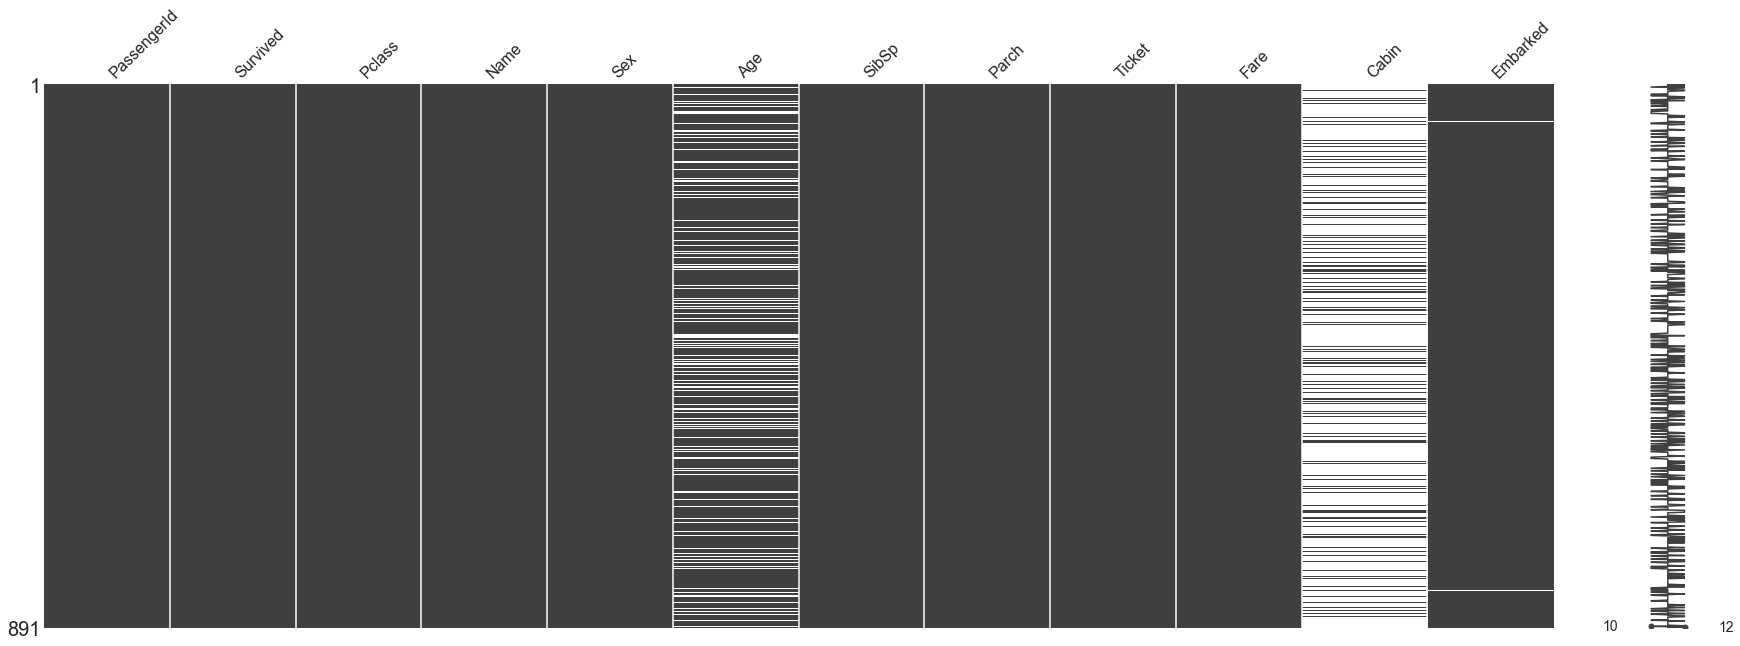

In [94]:
#visualize missing data
missingno.matrix(train, figsize = (30,10))

Age has 177 missing data, and cabin has 687 missing data and embarked has 2 missing data. Both the visualization and the table matches. I need to keep these 2 features in mind when processing each individual features

## Seperating Discrete and Continuous variables


In [95]:
df_bin = pd.DataFrame() # for discretized continuous variables
df_con = pd.DataFrame() # for continuous variables

In [96]:
train.dtypes #check for data types of all the variables

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Processing Individual Features

### Survived
Very simple data. 0 or 1 and there are no missing values

In [97]:
train['Survived']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [99]:
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### P-class
I need to check distribution to identify any possible outliers and deal with them accordingly


<AxesSubplot:xlabel='Pclass', ylabel='Density'>

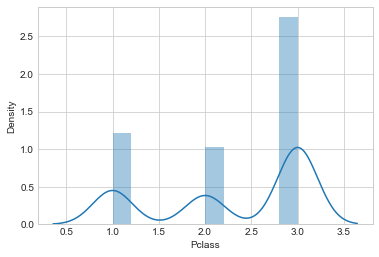

In [100]:
sns.distplot(train['Pclass'])

1, 2, 3 are all categorical data and there are no missing values for P-class.


In [101]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


### Name and Ticket

In [102]:
train[['Name','Ticket']].head(15)

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450
5,"Moran, Mr. James",330877
6,"McCarthy, Mr. Timothy J",17463
7,"Palsson, Master. Gosta Leonard",349909
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",347742
9,"Nasser, Mrs. Nicholas (Adele Achem)",237736


Both of these features can be ignored. Each one is unique and has very little significance to the model. Ticket also is unimportant because Pclass already contains information regarding the class, which is more significant than ticket.

### Sex

In [103]:
train['Sex']

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [104]:
#train['Sex']=train['Sex'].map({'male':1, 'female':0}) #replace with dummy variables 0 for male and 1 for female
#train.head()# check mapping

#After trying to optimize my model, I used pd.get_dummies() to do this

In [105]:
df_bin['Sex'] = train['Sex']
df_con['Sex'] = train['Sex']
df_bin.head()

,Survived,Pclass,Sex
0,0,3,male
1,1,1,female
2,1,3,female
3,1,1,female
4,0,3,male


### Age
When considering age values, we can consider median of the entire age column, but that does not really make sense. So I have to consider using other features. For this, first I find the correlating coefficients between age and other features. 


In [106]:
df_all_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
5,Age,Age,1.000000
12,Age,Pclass,0.369226
16,Age,SibSp,0.308247
21,Age,Parch,0.189119
26,Age,Fare,0.096067
31,Age,Survived,0.077221
36,Age,PassengerId,0.036847


The highest correlation is between age and Pclass. But to make it even more accurate when filling in the age values, the sex of the passengers can also be considered. It makes sense for each gender in different classes to have different median values. 


In [107]:
age_by_pclass_sex = train.groupby(['Sex', 'Pclass']).median()['Age']
age_by_pclass_sex

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

- Females in Pclass 1 has a median age of 35
- Males in Pclass 1 has a median age of 40


- Females in Pclass 2 has a median age of 28
- Males in Pclass 2 has a median age of 30


- Females in Pclass 3 has a median age of 21
- Males in Pclass 2 has a median age of 25

The median age of each Pclass goes down for both males and females. I can use these values to fill in our missing data

In [108]:
train['Age'] = train.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
train['Age'].isnull().sum()

0

In [109]:
df_bin['Age']=pd.qcut(train['Age'], 10)  #Age is a continuous variable so I need to bin it; 
                                        #I found 10 groups to be the most accurate for my model
df_con['Age']=train['Age']

### Sib Sp (Siblings Spouse)


<AxesSubplot:xlabel='SibSp', ylabel='Density'>

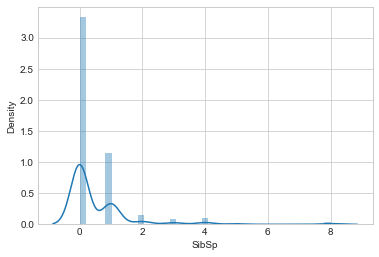

In [111]:
sns.distplot(train['SibSp'])

In [112]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [115]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp
0,0,3,male,"(20.0, 22.0]",1
1,1,1,female,"(34.0, 40.0]",1
2,1,3,female,"(25.0, 26.0]",0
3,1,1,female,"(34.0, 40.0]",1
4,0,3,male,"(34.0, 40.0]",0


In [116]:
df_con.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
dtype: int64

### Parch

<AxesSubplot:xlabel='Parch', ylabel='Density'>

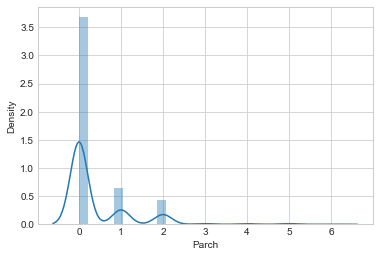

In [117]:
sns.distplot(train['Parch'])

In [118]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [122]:
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,"(20.0, 22.0]",1,0
1,1,1,female,"(34.0, 40.0]",1,0
2,1,3,female,"(25.0, 26.0]",0,0
3,1,1,female,"(34.0, 40.0]",1,0
4,0,3,male,"(34.0, 40.0]",0,0


### Fare


<AxesSubplot:xlabel='count', ylabel='Fare'>

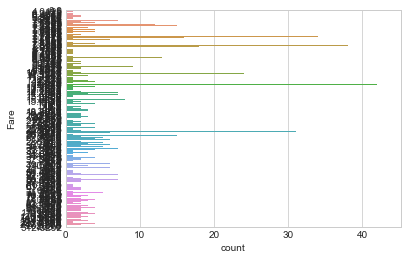

In [123]:
sns.countplot(y='Fare',data=train)

In [36]:
train.Fare.unique() # array of all unique values

array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
        51.8625,  21.075 ,  11.1333,  30.0708,  16.7   ,  26.55  ,
        31.275 ,   7.8542,  16.    ,  29.125 ,  13.    ,  18.    ,
         7.225 ,  26.    ,   8.0292,  35.5   ,  31.3875, 263.    ,
         7.8792,   7.8958,  27.7208, 146.5208,   7.75  ,  10.5   ,
        82.1708,  52.    ,   7.2292,  11.2417,   9.475 ,  21.    ,
        41.5792,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
        76.7292,  61.9792,  27.75  ,  46.9   ,  80.    ,  83.475 ,
        27.9   ,  15.2458,   8.1583,   8.6625,  73.5   ,  14.4542,
        56.4958,   7.65  ,  29.    ,  12.475 ,   9.    ,   9.5   ,
         7.7875,  47.1   ,  15.85  ,  34.375 ,  61.175 ,  20.575 ,
        34.6542,  63.3583,  23.    ,  77.2875,   8.6542,   7.775 ,
        24.15  ,   9.825 ,  14.4583, 247.5208,   7.1417,  22.3583,
         6.975 ,   7.05  ,  14.5   ,  15.0458,  26.2833,   9.2167,
        79.2   ,   6.75  ,  11.5   ,  36.75  ,   7.7958,  12.5

In [124]:
len(train.Fare.unique()) #len of array to check total unique values

248

In [125]:
df_con['Fare']=train['Fare']
#however, fare is continuous variable, so I need to bin first and change to categorical variable
df_bin['Fare']=pd.qcut(train['Fare'], 13)

<AxesSubplot:xlabel='Fare', ylabel='Density'>

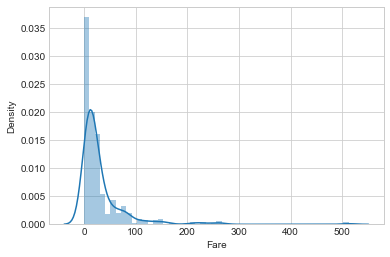

In [126]:
sns.distplot(train['Fare'])

### Cabin

<AxesSubplot:xlabel='count', ylabel='Cabin'>

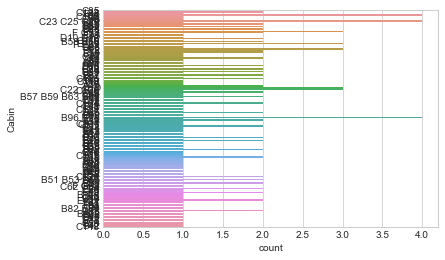

In [128]:
sns.countplot(y='Cabin',data=train)

In [56]:
len(train.Cabin.unique()) #len of the array of unique cabin values

147

In [57]:
train.Cabin.isnull().sum() #also cabin has 687 missing values
#will not use it for my initial models

687

### Embarked


<AxesSubplot:xlabel='count', ylabel='Embarked'>

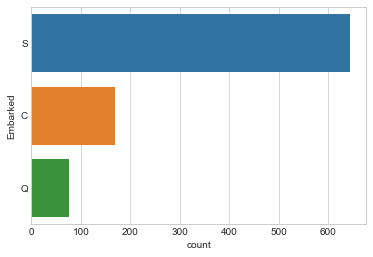

In [129]:
sns.countplot(y='Embarked', data=train)

In [130]:
#remember, embarked 2 missing values
train.Embarked.isnull().sum()

2

In [134]:
#drop the 2 rows with missing values
train = train.dropna(subset=['Embarked'])
train.Embarked.isnull().sum()

0

In [137]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

## Feature Encoding


In [142]:
df_bin

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,"(20.0, 22.0]",1,0,"(7.229, 7.75]",S
1,1,1,female,"(34.0, 40.0]",1,0,"(55.9, 83.158]",C
2,1,3,female,"(25.0, 26.0]",0,0,"(7.896, 8.05]",S
3,1,1,female,"(34.0, 40.0]",1,0,"(33.308, 55.9]",S
4,0,3,male,"(34.0, 40.0]",0,0,"(7.896, 8.05]",S
...,...,...,...,...,...,...,...,...
886,0,2,male,"(26.0, 30.0]",0,0,"(10.5, 13.0]",S
887,1,1,female,"(16.0, 20.0]",0,0,"(26.55, 33.308]",S
888,0,3,female,"(20.0, 22.0]",1,2,"(15.85, 24.0]",S
889,1,1,male,"(25.0, 26.0]",0,0,"(26.55, 33.308]",C


In [143]:
df_con

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,21.5,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Need to perform feature encoding for categorical variables 

<b> One Hot Encoding</b>

The categorical feature is not ordinal

<b> Label Encoding </b>

The categorical feature is ordinal

In [144]:
df_bin_dummies = pd.concat([df_bin, 
                      pd.get_dummies(df_bin['Pclass'],prefix='pclass', drop_first=True),
                       pd.get_dummies(df_bin['Embarked'],prefix='embarked', drop_first=True),
                           pd.get_dummies(df_bin['Sex'],prefix='sex', drop_first=True),], axis=1)


In [148]:
df_bin_dummies

,Survived,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,0,"(20.0, 22.0]",1,0,"(7.229, 7.75]",0,1,0,1,1
1,1,"(34.0, 40.0]",1,0,"(55.9, 83.158]",0,0,0,0,0
2,1,"(25.0, 26.0]",0,0,"(7.896, 8.05]",0,1,0,1,0
3,1,"(34.0, 40.0]",1,0,"(33.308, 55.9]",0,0,0,1,0
4,0,"(34.0, 40.0]",0,0,"(7.896, 8.05]",0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,0,"(26.0, 30.0]",0,0,"(10.5, 13.0]",1,0,0,1,1
887,1,"(16.0, 20.0]",0,0,"(26.55, 33.308]",0,0,0,1,0
888,0,"(20.0, 22.0]",1,2,"(15.85, 24.0]",0,1,0,1,0
889,1,"(25.0, 26.0]",0,0,"(26.55, 33.308]",0,0,0,0,1


In [ ]:
df_bin_dummies = df_bin_dummies.drop(['Pclass', 'Embarked', 'Sex'], axis=1)#dropping the original columns since I already generate dummies

In [150]:
df_bin_dummies

,Survived,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,0,"(20.0, 22.0]",1,0,"(7.229, 7.75]",0,1,0,1,1
1,1,"(34.0, 40.0]",1,0,"(55.9, 83.158]",0,0,0,0,0
2,1,"(25.0, 26.0]",0,0,"(7.896, 8.05]",0,1,0,1,0
3,1,"(34.0, 40.0]",1,0,"(33.308, 55.9]",0,0,0,1,0
4,0,"(34.0, 40.0]",0,0,"(7.896, 8.05]",0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,0,"(26.0, 30.0]",0,0,"(10.5, 13.0]",1,0,0,1,1
887,1,"(16.0, 20.0]",0,0,"(26.55, 33.308]",0,0,0,1,0
888,0,"(20.0, 22.0]",1,2,"(15.85, 24.0]",0,1,0,1,0
889,1,"(25.0, 26.0]",0,0,"(26.55, 33.308]",0,0,0,0,1


In [151]:
df_bin_dummies.dtypes

Survived         int64
Age           category
SibSp            int64
Parch            int64
Fare          category
pclass_2         uint8
pclass_3         uint8
embarked_Q       uint8
embarked_S       uint8
sex_male         uint8
dtype: object

# Building ML Training Models
When building my models, I found out that the Random Forest Classifer is throwing an error because of Age and Fare are category data types.

In [152]:
df_training=df_bin_dummies

In [153]:
df_training.head()

,Survived,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,0,"(20.0, 22.0]",1,0,"(7.229, 7.75]",0,1,0,1,1
1,1,"(34.0, 40.0]",1,0,"(55.9, 83.158]",0,0,0,0,0
2,1,"(25.0, 26.0]",0,0,"(7.896, 8.05]",0,1,0,1,0
3,1,"(34.0, 40.0]",1,0,"(33.308, 55.9]",0,0,0,1,0
4,0,"(34.0, 40.0]",0,0,"(7.896, 8.05]",0,1,0,1,1


In [154]:
y_train=df_training['Survived']
x_train=df_training.drop(['Survived'],axis=1)

In [156]:
x_train.head()

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,"(20.0, 22.0]",1,0,"(7.229, 7.75]",0,1,0,1,1
1,"(34.0, 40.0]",1,0,"(55.9, 83.158]",0,0,0,0,0
2,"(25.0, 26.0]",0,0,"(7.896, 8.05]",0,1,0,1,0
3,"(34.0, 40.0]",1,0,"(33.308, 55.9]",0,0,0,1,0
4,"(34.0, 40.0]",0,0,"(7.896, 8.05]",0,1,0,1,1


In [157]:
x_train['Fare']=x_train['Fare'].cat.codes
x_train['Age']=x_train['Age'].cat.codes
x_train.head()

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,2,1,0,1,0,1,0,1,1
1,7,1,0,11,0,0,0,0,0
2,4,0,0,3,0,1,0,1,0
3,7,1,0,10,0,0,0,1,0
4,7,0,0,3,0,1,0,1,1


In [159]:
x_train.dtypes #

Age            int8
SibSp         int64
Parch         int64
Fare           int8
pclass_2      uint8
pclass_3      uint8
embarked_Q    uint8
embarked_S    uint8
sex_male      uint8
dtype: object

In [160]:
x_train.isnull().sum()

Age           0
SibSp         0
Parch         0
Fare          0
pclass_2      0
pclass_3      0
embarked_Q    0
embarked_S    0
sex_male      0
dtype: int64

### Logistic Regression


In [ ]:
#build model
log_model=LogisticRegression().fit(x_train, y_train)

#calculate accuracy
acc_log = round(log_model.score(x_train, y_train) * 100, 2)

#cross validation
train_pred = model_selection.cross_val_predict(LogisticRegression(), 
                                                  x_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1)

#cross validation accuracy
acc_cv_log = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)

### K-Nearest Neighbor

In [162]:
#build model
knn_model=KNeighborsClassifier().fit(x_train, y_train)

#calculate accuracy
acc_knn = round(knn_model.score(x_train, y_train) * 100, 2)

#cross validation
train_pred = model_selection.cross_val_predict(KNeighborsClassifier(), 
                                                  x_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1)

#cross validation accuracy
acc_cv_knn = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)

Accuracy: 84.14
Accuracy CV 10-Fold: 76.6


### Gaussian Naive Bayes

In [163]:
#build model
gnb_model=GaussianNB().fit(x_train, y_train)

#calculate accuracy
acc_gnb = round(gnb_model.score(x_train, y_train) * 100, 2)

#cross validation
train_pred = model_selection.cross_val_predict(GaussianNB(), 
                                                  x_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1)

#cross validation accuracy
acc_cv_gnb = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_gnb)
print("Accuracy CV 10-Fold: %s" % acc_cv_gnb)

Accuracy: 76.38
Accuracy CV 10-Fold: 75.82


### Stochastic Gradient Descent

In [164]:
#build model
sgd_model=SGDClassifier().fit(x_train, y_train)

#calculate accuracy
acc_sgd = round(sgd_model.score(x_train, y_train) * 100, 2)

#cross validation
train_pred = model_selection.cross_val_predict(SGDClassifier(), 
                                                  x_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1)

#cross validation accuracy
acc_cv_sgd = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)

Accuracy: 71.32
Accuracy CV 10-Fold: 74.13


### Decision Tree Classifier

In [168]:
#build model
dtc_model=DecisionTreeClassifier().fit(x_train, y_train)

#calculate accuracy
acc_dtc = round(dtc_model.score(x_train, y_train) * 100, 2)

#cross validation
train_pred = model_selection.cross_val_predict(DecisionTreeClassifier(), 
                                                  x_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1)

#cross validation accuracy
acc_cv_dtc = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_dtc)
print("Accuracy CV 10-Fold: %s" % acc_cv_dtc)

Accuracy: 92.35
Accuracy CV 10-Fold: 78.18


### Gradient Boost Trees

In [197]:
#build model
gbt_model=GradientBoostingClassifier().fit(x_train, y_train)

#calculate accuracy
acc_gbt = round(gbt_model.score(x_train, y_train) * 100, 2)

#cross validation
gbt_model_cv = model_selection.cross_val_predict(GradientBoostingClassifier(), 
                                                  x_train, 
                                                  y_train, 
                                                  cv=10, 
                                                  n_jobs = -1)

#cross validation accuracy
acc_cv_gbt = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)

Accuracy: 86.05
Accuracy CV 10-Fold: 78.18


### Random Forest Classifier

In [205]:
#build model
rfc_model=RandomForestClassifier().fit(x_train, y_train)

#calculate accuracy
acc_rfc = round(gbt_model.score(x_train, y_train) * 100, 2)
#cross validation
rfc_model_cv = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1).fit(x_train, y_train)


#cross validation accuracy
acc_cv_rfc = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

print("Accuracy: %s" % acc_rfc)
print("Accuracy CV 10-Fold: %s" % acc_cv_rfc)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    1.2s finished


Accuracy: 86.05
Accuracy CV 10-Fold: 78.18


### Accuracy Scores


In [171]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 
              'Logistic Regression', 
              'Naive Bayes', 
              'Stochastic Gradient Decent', 
              'Decision Tree',
              'Gradient Boosting Trees',
              'Random Forest Classifier',],
    'Score': [
        acc_knn, 
        acc_log,      
        acc_gnb, 
        acc_sgd,
        acc_dtc,
        acc_gbt,
        acc_rfc
    ]})
print('---Regular Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Regular Accuracy Scores---


,Model,Score
4,Decision Tree,92.35
5,Gradient Boosting Trees,86.05
6,Random Forest Classifier,86.05
0,KNN,84.14
1,Logistic Regression,80.31
2,Naive Bayes,76.38
3,Stochastic Gradient Decent,71.32


In [231]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 
              'Logistic Regression', 
              'Naive Bayes', 
              'Stochastic Gradient Decent', 
              'Decision Tree',
              'Gradient Boosting Trees',
              'Random Forest Classifier',],
    'Score': [acc_cv_knn,  
              acc_cv_log,      
              acc_cv_gnb, 
              acc_cv_sgd,
              acc_cv_dtc,
              acc_cv_gbt,
              acc_cv_rfc]
    })
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
1,Logistic Regression,79.98
4,Decision Tree,78.18
5,Gradient Boosting Trees,78.18
6,Random Forest Classifier,78.18
0,KNN,76.60
2,Naive Bayes,75.82
3,Stochastic Gradient Decent,74.13


# Catboost

In [232]:
x_train.head()

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,2,1,0,1,0,1,0,1,1
1,7,1,0,11,0,0,0,0,0
2,4,0,0,3,0,1,0,1,0
3,7,1,0,10,0,0,0,1,0
4,7,0,0,3,0,1,0,1,1


In [233]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Defining features for catboost


In [279]:
cat_features = np.where(x_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [280]:
cb_pool=Pool(x_train, 
             y_train,
             cat_features)

### Creating the model

In [281]:
catboost_model = CatBoostClassifier(task_type='GPU',                                    
                                    iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

catboost_model.fit(cb_pool,
                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.03393
0:	learn: 0.6768156	total: 50.2ms	remaining: 50.2s
1:	learn: 0.6636576	total: 90.8ms	remaining: 45.3s
2:	learn: 0.6517485	total: 139ms	remaining: 46.1s
3:	learn: 0.6391913	total: 172ms	remaining: 42.9s
4:	learn: 0.6282030	total: 222ms	remaining: 44.2s
5:	learn: 0.6180740	total: 263ms	remaining: 43.6s
6:	learn: 0.6081794	total: 296ms	remaining: 42s
7:	learn: 0.5997507	total: 348ms	remaining: 43.2s
8:	learn: 0.5913288	total: 381ms	remaining: 42s
9:	learn: 0.5866052	total: 429ms	remaining: 42.5s
10:	learn: 0.5788405	total: 478ms	remaining: 43s
11:	learn: 0.5722000	total: 527ms	remaining: 43.4s
12:	learn: 0.5661387	total: 572ms	remaining: 43.4s
13:	learn: 0.5604887	total: 614ms	remaining: 43.2s
14:	learn: 0.5574610	total: 658ms	remaining: 43.2s
15:	learn: 0.5525464	total: 697ms	remaining: 42.8s
16:	learn: 0.5474013	total: 740ms	remaining: 42.8s
17:	learn: 0.5416238	total: 782ms	remaining: 42.7s
18:	learn: 0.5372980	total: 827ms	remaining: 42.7s
19:	learn: 0.533

165:	learn: 0.3889969	total: 6.75s	remaining: 33.9s
166:	learn: 0.3888638	total: 6.8s	remaining: 33.9s
167:	learn: 0.3888586	total: 6.83s	remaining: 33.8s
168:	learn: 0.3888534	total: 6.86s	remaining: 33.7s
169:	learn: 0.3879836	total: 6.9s	remaining: 33.7s
170:	learn: 0.3879430	total: 6.94s	remaining: 33.6s
171:	learn: 0.3878074	total: 6.98s	remaining: 33.6s
172:	learn: 0.3876925	total: 7.02s	remaining: 33.6s
173:	learn: 0.3876819	total: 7.07s	remaining: 33.5s
174:	learn: 0.3876788	total: 7.1s	remaining: 33.5s
175:	learn: 0.3876283	total: 7.14s	remaining: 33.4s
176:	learn: 0.3874287	total: 7.18s	remaining: 33.4s
177:	learn: 0.3873624	total: 7.23s	remaining: 33.4s
178:	learn: 0.3872555	total: 7.26s	remaining: 33.3s
179:	learn: 0.3872507	total: 7.3s	remaining: 33.3s
180:	learn: 0.3872505	total: 7.34s	remaining: 33.2s
181:	learn: 0.3872355	total: 7.38s	remaining: 33.2s
182:	learn: 0.3871876	total: 7.42s	remaining: 33.1s
183:	learn: 0.3870193	total: 7.46s	remaining: 33.1s
184:	learn: 0.38

324:	learn: 0.3636558	total: 13s	remaining: 27.1s
325:	learn: 0.3636492	total: 13.1s	remaining: 27s
326:	learn: 0.3636474	total: 13.1s	remaining: 27s
327:	learn: 0.3636151	total: 13.2s	remaining: 26.9s
328:	learn: 0.3635512	total: 13.2s	remaining: 26.9s
329:	learn: 0.3632497	total: 13.2s	remaining: 26.9s
330:	learn: 0.3632406	total: 13.3s	remaining: 26.8s
331:	learn: 0.3625669	total: 13.3s	remaining: 26.8s
332:	learn: 0.3625426	total: 13.3s	remaining: 26.7s
333:	learn: 0.3621804	total: 13.4s	remaining: 26.7s
334:	learn: 0.3618595	total: 13.4s	remaining: 26.7s
335:	learn: 0.3618292	total: 13.5s	remaining: 26.6s
336:	learn: 0.3618152	total: 13.5s	remaining: 26.6s
337:	learn: 0.3617616	total: 13.5s	remaining: 26.5s
338:	learn: 0.3616853	total: 13.6s	remaining: 26.5s
339:	learn: 0.3614769	total: 13.6s	remaining: 26.4s
340:	learn: 0.3612058	total: 13.7s	remaining: 26.4s
341:	learn: 0.3608097	total: 13.7s	remaining: 26.4s
342:	learn: 0.3606934	total: 13.7s	remaining: 26.3s
343:	learn: 0.3604

487:	learn: 0.3390451	total: 19.6s	remaining: 20.6s
488:	learn: 0.3390111	total: 19.6s	remaining: 20.5s
489:	learn: 0.3388840	total: 19.7s	remaining: 20.5s
490:	learn: 0.3387906	total: 19.7s	remaining: 20.4s
491:	learn: 0.3383622	total: 19.8s	remaining: 20.4s
492:	learn: 0.3380848	total: 19.8s	remaining: 20.4s
493:	learn: 0.3379984	total: 19.9s	remaining: 20.3s
494:	learn: 0.3377349	total: 19.9s	remaining: 20.3s
495:	learn: 0.3373366	total: 19.9s	remaining: 20.3s
496:	learn: 0.3369838	total: 20s	remaining: 20.2s
497:	learn: 0.3365030	total: 20s	remaining: 20.2s
498:	learn: 0.3363736	total: 20.1s	remaining: 20.2s
499:	learn: 0.3360629	total: 20.1s	remaining: 20.1s
500:	learn: 0.3359318	total: 20.2s	remaining: 20.1s
501:	learn: 0.3358055	total: 20.2s	remaining: 20s
502:	learn: 0.3355495	total: 20.2s	remaining: 20s
503:	learn: 0.3353504	total: 20.3s	remaining: 20s
504:	learn: 0.3351294	total: 20.3s	remaining: 19.9s
505:	learn: 0.3351286	total: 20.3s	remaining: 19.9s
506:	learn: 0.3347225	

649:	learn: 0.3173084	total: 25.7s	remaining: 13.9s
650:	learn: 0.3172037	total: 25.8s	remaining: 13.8s
651:	learn: 0.3170851	total: 25.8s	remaining: 13.8s
652:	learn: 0.3170849	total: 25.9s	remaining: 13.7s
653:	learn: 0.3170848	total: 25.9s	remaining: 13.7s
654:	learn: 0.3170784	total: 25.9s	remaining: 13.7s
655:	learn: 0.3170640	total: 26s	remaining: 13.6s
656:	learn: 0.3169256	total: 26s	remaining: 13.6s
657:	learn: 0.3169120	total: 26s	remaining: 13.5s
658:	learn: 0.3167751	total: 26.1s	remaining: 13.5s
659:	learn: 0.3167749	total: 26.1s	remaining: 13.4s
660:	learn: 0.3167622	total: 26.1s	remaining: 13.4s
661:	learn: 0.3166764	total: 26.2s	remaining: 13.4s
662:	learn: 0.3162372	total: 26.2s	remaining: 13.3s
663:	learn: 0.3162214	total: 26.2s	remaining: 13.3s
664:	learn: 0.3162098	total: 26.3s	remaining: 13.2s
665:	learn: 0.3160675	total: 26.3s	remaining: 13.2s
666:	learn: 0.3160380	total: 26.4s	remaining: 13.2s
667:	learn: 0.3160241	total: 26.4s	remaining: 13.1s
668:	learn: 0.3160

810:	learn: 0.3057695	total: 31.6s	remaining: 7.36s
811:	learn: 0.3057335	total: 31.6s	remaining: 7.31s
812:	learn: 0.3057152	total: 31.6s	remaining: 7.28s
813:	learn: 0.3057086	total: 31.7s	remaining: 7.24s
814:	learn: 0.3056775	total: 31.7s	remaining: 7.2s
815:	learn: 0.3054279	total: 31.8s	remaining: 7.16s
816:	learn: 0.3053441	total: 31.8s	remaining: 7.12s
817:	learn: 0.3053406	total: 31.8s	remaining: 7.08s
818:	learn: 0.3052668	total: 31.9s	remaining: 7.04s
819:	learn: 0.3047348	total: 31.9s	remaining: 7s
820:	learn: 0.3047313	total: 31.9s	remaining: 6.96s
821:	learn: 0.3046584	total: 32s	remaining: 6.92s
822:	learn: 0.3046525	total: 32s	remaining: 6.88s
823:	learn: 0.3046441	total: 32s	remaining: 6.84s
824:	learn: 0.3046350	total: 32.1s	remaining: 6.8s
825:	learn: 0.3045590	total: 32.1s	remaining: 6.77s
826:	learn: 0.3044727	total: 32.2s	remaining: 6.73s
827:	learn: 0.3042842	total: 32.2s	remaining: 6.69s
828:	learn: 0.3041223	total: 32.2s	remaining: 6.65s
829:	learn: 0.3041189	t

974:	learn: 0.2932532	total: 37.8s	remaining: 969ms
975:	learn: 0.2932513	total: 37.8s	remaining: 930ms
976:	learn: 0.2931462	total: 37.9s	remaining: 892ms
977:	learn: 0.2931452	total: 37.9s	remaining: 853ms
978:	learn: 0.2931269	total: 37.9s	remaining: 814ms
979:	learn: 0.2930883	total: 38s	remaining: 775ms
980:	learn: 0.2930237	total: 38s	remaining: 737ms
981:	learn: 0.2929645	total: 38.1s	remaining: 698ms
982:	learn: 0.2928060	total: 38.1s	remaining: 659ms
983:	learn: 0.2925451	total: 38.2s	remaining: 620ms
984:	learn: 0.2921606	total: 38.2s	remaining: 582ms
985:	learn: 0.2921605	total: 38.2s	remaining: 543ms
986:	learn: 0.2921602	total: 38.3s	remaining: 504ms
987:	learn: 0.2921598	total: 38.3s	remaining: 465ms
988:	learn: 0.2921156	total: 38.3s	remaining: 426ms
989:	learn: 0.2921085	total: 38.4s	remaining: 388ms
990:	learn: 0.2920399	total: 38.4s	remaining: 349ms
991:	learn: 0.2919848	total: 38.4s	remaining: 310ms
992:	learn: 0.2919505	total: 38.5s	remaining: 271ms
993:	learn: 0.29

In [282]:
acc_catboost = round(catboost_model.score(x_train, y_train) * 100, 2)
acc_catboost

86.05

### Catboost Cross Validation

In [283]:
start_time = time.time()
cv_params = catboost_model.get_params() #cross validation parameters the same as model
cv_params

{'iterations': 1000,
 'loss_function': 'Logloss',
 'custom_loss': ['Accuracy'],
 'task_type': 'GPU'}

In [272]:
cv_params

{'iterations': 1000, 'loss_function': 'Logloss', 'custom_loss': ['Accuracy']}

In [285]:
cv_data = cv(cb_pool,
             cv_params,          
            fold_count=10,
            plot=True)
catboost_time = (time.time() - start_time)
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6800937	test: 0.6795816	best: 0.6795816 (0)	total: 5.17s	remaining: 1h 26m
1:	learn: 0.6679898	test: 0.6668442	best: 0.6668442 (1)
2:	learn: 0.6569357	test: 0.6557209	best: 0.6557209 (2)	total: 10.3s	remaining: 56m 49s
3:	learn: 0.6460879	test: 0.6446829	best: 0.6446829 (3)	total: 15.3s	remaining: 1h 3m 21s
4:	learn: 0.6359395	test: 0.6344535	best: 0.6344535 (4)
5:	learn: 0.6271162	test: 0.6255232	best: 0.6255232 (5)	total: 21s	remaining: 58m 3s
6:	learn: 0.6179346	test: 0.6163681	best: 0.6163681 (6)
7:	learn: 0.6101902	test: 0.6083087	best: 0.6083087 (7)
8:	learn: 0.6023300	test: 0.6004619	best: 0.6004619 (8)
9:	learn: 0.5947935	test: 0.5928411	best: 0.5928411 (9)	total: 28.2s	remaining: 46m 32s
10:	learn: 0.5877517	test: 0.5858656	best: 0.5858656 (10)	total: 34.4s	remaining: 51m 31s
11:	learn: 0.5810377	test: 0.5794010	best: 0.5794010 (11)	total: 41.2s	remaining: 56m 31s
12:	learn: 0.5750110	test: 0.5735807	best: 0.5735807 (12)	total: 48.1s	remaining: 1h 48s
13:	learn: 0.

120:	learn: 0.4136096	test: 0.4431504	best: 0.4431504 (120)
121:	learn: 0.4133236	test: 0.4430911	best: 0.4430911 (121)
122:	learn: 0.4130171	test: 0.4429457	best: 0.4429457 (122)
123:	learn: 0.4127175	test: 0.4426469	best: 0.4426469 (123)
124:	learn: 0.4118112	test: 0.4421550	best: 0.4421550 (124)	total: 4m 56s	remaining: 34m 34s
125:	learn: 0.4114508	test: 0.4418966	best: 0.4418966 (125)
126:	learn: 0.4111846	test: 0.4418646	best: 0.4418646 (126)	total: 5m 2s	remaining: 34m 36s
127:	learn: 0.4109111	test: 0.4417789	best: 0.4417789 (127)
128:	learn: 0.4107286	test: 0.4418305	best: 0.4417789 (127)
129:	learn: 0.4103798	test: 0.4417461	best: 0.4417461 (129)	total: 5m 7s	remaining: 34m 21s
130:	learn: 0.4099246	test: 0.4413723	best: 0.4413723 (130)
131:	learn: 0.4097884	test: 0.4413866	best: 0.4413723 (130)	total: 5m 13s	remaining: 34m 22s
132:	learn: 0.4093757	test: 0.4411755	best: 0.4411755 (132)
133:	learn: 0.4091642	test: 0.4411727	best: 0.4411727 (133)
134:	learn: 0.4089230	test: 0.

236:	learn: 0.3815934	test: 0.4356649	best: 0.4356649 (236)
237:	learn: 0.3814683	test: 0.4357281	best: 0.4356649 (236)	total: 9m 37s	remaining: 30m 47s
238:	learn: 0.3812288	test: 0.4356817	best: 0.4356649 (236)
239:	learn: 0.3810047	test: 0.4357284	best: 0.4356649 (236)	total: 9m 43s	remaining: 30m 48s
240:	learn: 0.3807614	test: 0.4356079	best: 0.4356079 (240)	total: 9m 49s	remaining: 30m 56s
241:	learn: 0.3804369	test: 0.4354141	best: 0.4354141 (241)	total: 9m 54s	remaining: 31m 2s
242:	learn: 0.3802242	test: 0.4354277	best: 0.4354141 (241)
243:	learn: 0.3800879	test: 0.4354482	best: 0.4354141 (241)
244:	learn: 0.3799591	test: 0.4354315	best: 0.4354141 (241)
245:	learn: 0.3798049	test: 0.4354288	best: 0.4354141 (241)	total: 10m	remaining: 30m 41s
246:	learn: 0.3796223	test: 0.4352793	best: 0.4352793 (246)
247:	learn: 0.3795119	test: 0.4354242	best: 0.4352793 (246)
248:	learn: 0.3794240	test: 0.4355806	best: 0.4352793 (246)	total: 10m 6s	remaining: 30m 30s
249:	learn: 0.3791610	test

342:	learn: 0.3611052	test: 0.4377029	best: 0.4352793 (246)
343:	learn: 0.3609584	test: 0.4375261	best: 0.4352793 (246)
344:	learn: 0.3608231	test: 0.4375533	best: 0.4352793 (246)	total: 15m 8s	remaining: 28m 45s
345:	learn: 0.3606193	test: 0.4375971	best: 0.4352793 (246)
346:	learn: 0.3605381	test: 0.4376122	best: 0.4352793 (246)	total: 15m 14s	remaining: 28m 41s
347:	learn: 0.3603796	test: 0.4375469	best: 0.4352793 (246)
348:	learn: 0.3602115	test: 0.4374527	best: 0.4352793 (246)
349:	learn: 0.3601230	test: 0.4374977	best: 0.4352793 (246)
350:	learn: 0.3600033	test: 0.4375424	best: 0.4352793 (246)
351:	learn: 0.3598077	test: 0.4374442	best: 0.4352793 (246)	total: 15m 21s	remaining: 28m 16s
352:	learn: 0.3595852	test: 0.4373931	best: 0.4352793 (246)	total: 15m 27s	remaining: 28m 19s
353:	learn: 0.3594148	test: 0.4373323	best: 0.4352793 (246)	total: 15m 32s	remaining: 28m 22s
354:	learn: 0.3591183	test: 0.4373248	best: 0.4352793 (246)
355:	learn: 0.3589343	test: 0.4374387	best: 0.43527

456:	learn: 0.3427337	test: 0.4389892	best: 0.4352793 (246)	total: 19m 19s	remaining: 22m 57s
457:	learn: 0.3425377	test: 0.4388398	best: 0.4352793 (246)
458:	learn: 0.3423199	test: 0.4390287	best: 0.4352793 (246)
459:	learn: 0.3422832	test: 0.4390787	best: 0.4352793 (246)
460:	learn: 0.3421397	test: 0.4389479	best: 0.4352793 (246)
461:	learn: 0.3419516	test: 0.4389093	best: 0.4352793 (246)
462:	learn: 0.3418218	test: 0.4389060	best: 0.4352793 (246)
463:	learn: 0.3417235	test: 0.4389073	best: 0.4352793 (246)
464:	learn: 0.3415083	test: 0.4389282	best: 0.4352793 (246)	total: 19m 28s	remaining: 22m 23s
465:	learn: 0.3412339	test: 0.4388866	best: 0.4352793 (246)
466:	learn: 0.3410675	test: 0.4389718	best: 0.4352793 (246)	total: 19m 34s	remaining: 22m 20s
467:	learn: 0.3408925	test: 0.4390043	best: 0.4352793 (246)	total: 19m 39s	remaining: 22m 20s
468:	learn: 0.3407555	test: 0.4390040	best: 0.4352793 (246)
469:	learn: 0.3405858	test: 0.4390518	best: 0.4352793 (246)
470:	learn: 0.3404428	te

568:	learn: 0.3273874	test: 0.4410774	best: 0.4352793 (246)
569:	learn: 0.3273156	test: 0.4410813	best: 0.4352793 (246)
570:	learn: 0.3272920	test: 0.4410830	best: 0.4352793 (246)
571:	learn: 0.3271984	test: 0.4411114	best: 0.4352793 (246)	total: 24m 4s	remaining: 18m 1s
572:	learn: 0.3270881	test: 0.4410712	best: 0.4352793 (246)	total: 24m 10s	remaining: 18m
573:	learn: 0.3270122	test: 0.4411334	best: 0.4352793 (246)	total: 24m 15s	remaining: 18m
574:	learn: 0.3269029	test: 0.4412393	best: 0.4352793 (246)
575:	learn: 0.3268086	test: 0.4412815	best: 0.4352793 (246)
576:	learn: 0.3267442	test: 0.4413361	best: 0.4352793 (246)	total: 24m 21s	remaining: 17m 51s
577:	learn: 0.3266335	test: 0.4413159	best: 0.4352793 (246)
578:	learn: 0.3265872	test: 0.4414079	best: 0.4352793 (246)
579:	learn: 0.3265568	test: 0.4413978	best: 0.4352793 (246)
580:	learn: 0.3264298	test: 0.4414645	best: 0.4352793 (246)	total: 24m 27s	remaining: 17m 38s
581:	learn: 0.3263708	test: 0.4414744	best: 0.4352793 (246)


683:	learn: 0.3166522	test: 0.4447580	best: 0.4352793 (246)	total: 28m 32s	remaining: 13m 11s
684:	learn: 0.3165180	test: 0.4447060	best: 0.4352793 (246)
685:	learn: 0.3164347	test: 0.4447011	best: 0.4352793 (246)	total: 28m 38s	remaining: 13m 6s
686:	learn: 0.3163438	test: 0.4447474	best: 0.4352793 (246)	total: 28m 43s	remaining: 13m 5s
687:	learn: 0.3162507	test: 0.4447730	best: 0.4352793 (246)
688:	learn: 0.3161891	test: 0.4448632	best: 0.4352793 (246)
689:	learn: 0.3161367	test: 0.4449091	best: 0.4352793 (246)
690:	learn: 0.3159610	test: 0.4449813	best: 0.4352793 (246)	total: 28m 49s	remaining: 12m 53s
691:	learn: 0.3158185	test: 0.4449278	best: 0.4352793 (246)	total: 28m 55s	remaining: 12m 52s
692:	learn: 0.3156955	test: 0.4449393	best: 0.4352793 (246)	total: 29m	remaining: 12m 50s
693:	learn: 0.3155897	test: 0.4449675	best: 0.4352793 (246)
694:	learn: 0.3154461	test: 0.4449688	best: 0.4352793 (246)
695:	learn: 0.3153864	test: 0.4450674	best: 0.4352793 (246)	total: 29m 6s	remainin

798:	learn: 0.3065253	test: 0.4474265	best: 0.4352793 (246)	total: 33m 54s	remaining: 8m 31s
799:	learn: 0.3064368	test: 0.4474773	best: 0.4352793 (246)	total: 34m 1s	remaining: 8m 30s
800:	learn: 0.3063606	test: 0.4474856	best: 0.4352793 (246)	total: 34m 9s	remaining: 8m 29s
801:	learn: 0.3063098	test: 0.4476207	best: 0.4352793 (246)
802:	learn: 0.3062097	test: 0.4476020	best: 0.4352793 (246)
803:	learn: 0.3061849	test: 0.4476126	best: 0.4352793 (246)
804:	learn: 0.3061102	test: 0.4475818	best: 0.4352793 (246)
805:	learn: 0.3060463	test: 0.4476400	best: 0.4352793 (246)
806:	learn: 0.3059486	test: 0.4477150	best: 0.4352793 (246)	total: 34m 18s	remaining: 8m 12s
807:	learn: 0.3058915	test: 0.4477347	best: 0.4352793 (246)	total: 34m 26s	remaining: 8m 11s
808:	learn: 0.3058281	test: 0.4477119	best: 0.4352793 (246)	total: 34m 33s	remaining: 8m 9s
809:	learn: 0.3057967	test: 0.4477623	best: 0.4352793 (246)	total: 34m 40s	remaining: 8m 8s
810:	learn: 0.3057329	test: 0.4476958	best: 0.4352793

902:	learn: 0.2981507	test: 0.4512375	best: 0.4352793 (246)	total: 41m 35s	remaining: 4m 28s
903:	learn: 0.2980383	test: 0.4513305	best: 0.4352793 (246)	total: 41m 43s	remaining: 4m 25s
904:	learn: 0.2978574	test: 0.4513578	best: 0.4352793 (246)
905:	learn: 0.2977037	test: 0.4516016	best: 0.4352793 (246)
906:	learn: 0.2976801	test: 0.4516070	best: 0.4352793 (246)	total: 41m 51s	remaining: 4m 17s
907:	learn: 0.2975513	test: 0.4515615	best: 0.4352793 (246)
908:	learn: 0.2974781	test: 0.4516534	best: 0.4352793 (246)
909:	learn: 0.2974484	test: 0.4516595	best: 0.4352793 (246)
910:	learn: 0.2973514	test: 0.4516402	best: 0.4352793 (246)
911:	learn: 0.2972485	test: 0.4516630	best: 0.4352793 (246)
912:	learn: 0.2971417	test: 0.4517134	best: 0.4352793 (246)
913:	learn: 0.2970404	test: 0.4517100	best: 0.4352793 (246)
914:	learn: 0.2969788	test: 0.4517943	best: 0.4352793 (246)	total: 42m 1s	remaining: 3m 54s
915:	learn: 0.2968753	test: 0.4518336	best: 0.4352793 (246)	total: 42m 7s	remaining: 3m 5

In [289]:
acc_cv_catboost

82.45

# Testing Models


In [173]:
raw_test=pd.read_csv('data/test.csv')

In [174]:
x_train.head()

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,2,1,0,1,0,1,0,1,1
1,7,1,0,11,0,0,0,0,0
2,4,0,0,3,0,1,0,1,0
3,7,1,0,10,0,0,0,1,0
4,7,0,0,3,0,1,0,1,1


In [175]:
raw_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Process Test Data the Same way

In [177]:
df_test = pd.concat([raw_test, 
                      pd.get_dummies(raw_test['Pclass'],prefix='pclass', drop_first=True),
                       pd.get_dummies(raw_test['Embarked'],prefix='embarked', drop_first=True),
                         pd.get_dummies(raw_test['Sex'],prefix='sex', drop_first=True)], axis=1)


In [178]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,1,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,1,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,1,0,1,0


In [180]:
test_columns=x_train.columns #take the list of columns used in my training data
test_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'pclass_2', 'pclass_3', 'embarked_Q',
       'embarked_S', 'sex_male'],
      dtype='object')

In [181]:
df_test[test_columns]

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,34.5,0,0,7.8292,0,1,1,0,1
1,47.0,1,0,7.0000,0,1,0,1,0
2,62.0,0,0,9.6875,1,0,1,0,1
3,27.0,0,0,8.6625,0,1,0,1,1
4,22.0,1,1,12.2875,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
413,NaN,0,0,8.0500,0,1,0,1,1
414,39.0,0,0,108.9000,0,0,0,0,0
415,38.5,0,0,7.2500,0,1,0,1,1
416,NaN,0,0,8.0500,0,1,0,1,1


## Fix missing values

In [182]:
df_test[test_columns].isnull().sum()

Age           86
SibSp          0
Parch          0
Fare           1
pclass_2       0
pclass_3       0
embarked_Q     0
embarked_S     0
sex_male       0
dtype: int64

### Fix missing Fare Value

In [183]:
#Because it is just one cell, I am going to insert the average of the fare column
fare_mean=df_test['Fare'].mean()
fare_mean

35.6271884892086

In [184]:
df_test['Fare']=df_test['Fare'].fillna(fare_mean)

In [185]:
df_test['Fare'].isnull().sum()

0

### Fix missing Age Values

In [186]:
df_test['Age'].isnull().sum()

86

In [187]:
df_test['Age'] = df_test.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())) 
#fill it the same way for my training data

In [188]:
df_test['Age'].isnull().sum()

0

## Bin continuous variables and change categorical variables to integers

In [189]:
df_test['Fare']=pd.qcut(df_test['Fare'], 13)
df_test['Fare']=df_test['Fare'].cat.codes


In [190]:
df_test[test_columns]

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,34.5,0,0,2,0,1,1,0,1
1,47.0,1,0,0,0,1,0,1,0
2,62.0,0,0,4,1,0,1,0,1
3,27.0,0,0,4,0,1,0,1,1
4,22.0,1,1,5,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
413,24.0,0,0,3,0,1,0,1,1
414,39.0,0,0,12,0,0,0,0,0
415,38.5,0,0,0,0,1,0,1,1
416,24.0,0,0,3,0,1,0,1,1


In [191]:
df_test['Age']=pd.qcut(df_test['Age'], 10)
df_test['Age']=df_test['Age'].cat.codes


In [192]:
df_test[test_columns]

,Age,SibSp,Parch,Fare,pclass_2,pclass_3,embarked_Q,embarked_S,sex_male
0,7,0,0,2,0,1,1,0,1
1,8,1,0,0,0,1,0,1,0
2,9,0,0,4,1,0,1,0,1
3,5,0,0,4,0,1,0,1,1
4,2,1,1,5,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
413,3,0,0,3,0,1,0,1,1
414,7,0,0,12,0,0,0,0,0
415,7,0,0,0,0,1,0,1,1
416,3,0,0,3,0,1,0,1,1


# Predictions

In [222]:
predictions=rfc_model_cv.predict(df_test[test_columns])
predictions

#acc_rfc = round(rfc_model_cv.score(x_train, y_train) * 100, 2)
#acc_rfc

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1100 out of 1100 | elapsed:    0.1s finished


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [213]:
predictions_gbt = gbt_model.predict(df_test[test_columns])
predictions_gbt

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

### Catboost prediction

In [291]:
predictions_cat= catboost_model.predict(df_test[test_columns])
submission = pd.DataFrame()
submission['PassengerId'] =df_test['PassengerId']
submission['Survived'] = predictions_cat # our model predictions on the test dataset
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [295]:
# Create a submisison dataframe and append the relevant columns
submission_cat = pd.DataFrame()
submission_cat['PassengerId'] =df_test['PassengerId']
submission_cat['Survived'] = predictions # our model predictions on the test dataset
submission_cat

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [297]:
submission_cat['Survived'] = submission_cat['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [299]:
submission_cat.to_csv('../submission__cat.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [225]:
submission_final = pd.DataFrame()
submission_final['PassengerId'] =df_test['PassengerId']
submission_final['Survived'] = predictions # our model predictions on the test dataset
submission_final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [215]:
# Submission for gbt model out of curiousity
submission_gbt = pd.DataFrame()
submission_gbt['PassengerId'] =df_test['PassengerId']
submission_gbt['Survived'] = predictions_gbt # our model predictions on the test dataset
submission_gbt

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [226]:
submission_final['Survived'] = submission_final['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [227]:
submission_final.to_csv('../submission_final.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [228]:
my_submission=pd.read_csv('../submission_final.csv')

In [595]:
submission_overfitted_read=pd.read_csv('../submission_overfitted.csv')

In [220]:
my_submission[submission['Survived'] == 0].count()

PassengerId    275
Survived       275
dtype: int64